In [1]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from pandas import DataFrame
from pandas import concat

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor

import pickle
from pathlib import Path

import random
import os

from statistics import mean

# Content
#### [Introduction](#introduction)
#### [Executive Summary](#executive)
#### [Time series prediction approached with tabular regression](#time_series)
#### [Dive in. Easy come easy go.](#dive_in)
#### [One model or many models?](#one_model)
#### [How much lagged data do we need?](#how_much_lagged)
#### [How much data do we need?](#how_much_data)
#### [Test (almost) all the data](#test_all)
#### [Conclusion](#conclusion)
#### [External links](#external_links)

<a id='introduction'></a>

## Introduction

This work is part of a Data Science Nanodegree at [Udacity](#itcp). It is an attempt to implement a stock predictor.

From the very beginning let's make clear this work has nothing to do with any investment objective. At no time there is any attempt to asses any profit following the predictive model described here. As such, it must be seen just an oportunity to exercise a few data science tools and methods.

The proposed objective is to obtain an average relative percentage error of +/- 5% of the actual value for up to 7 days in the future. The predicted value is Adjusted Close.

Predicting stock prices is notoriously hard not least because they are known to contain a lot of randomness. [Random Walks](#random_walks) and [Brownian motion](#brownian_motion) have been used to model stock prices - both are techniques modelling random events.

Given the above, predicting stock prices seems to be a hard task.

On the other hand, long term average stock market return seems to be fairly stable at around 10%, as reported [here](#asr_1) and [here](#asr_2) for example.

A 10% growth averaged over about 250 trading days per year, gives us hope that, at least for stable stocks with relatively low volatility, predicting with +/- 5% precision for up to 7 days in the future is achievable. So let's see.

<a id='executive'></a>

## Executive Summary

We employ a supervised learning approach where the features of the predicted value, Adjusted Close stock price (AC), are the AC values of the the same stock for the previous days.

We find that XGBoost and Random Forest regressors perform worse than a simple Linear regressor, while also taking abot 3 orders of magnitude more time to train a model.

We test a Linear regressor with 20 lagged values and find out that it performs on average within the objective +/- 5% relative error margin.

For testing we looked at a subset of the Nasdaq stocks with a market valuation of $1bn or more. This subset contains about 34% of the Nasdaq stock symbols, but make over 98% of the total Market Capitalisation of Nasdaq listed companies as of this date (December 2021). From this perspective we tested the predictor practically over the whole market.

<a id='time_series'></a>

## Time series prediction approached with tabular regression

### Source of Data

We are using data from [Yahoo Finance](#yfinance) for which there is a python module, pandas_datareader which can extract data programatically for a given stock symbol.

First, we'll define a function, get_symbol_data to retrieve the data from Yahoo Finance and store it on disk, if it has not been downloaded today.

In [2]:
def get_yahoo_symbol_data(symbol):
    """
    Retrieves daily trading data from Yahoo Finance. Saves it as file data/symbol.csv, overwriting any existing data.
    Arguments:
        symbol: string, stock symbol i.e GOOG, TSLA
        start_date: start date of the retrieved data set as a datetime object
    Returns:
        Pandas DataFrame with the following columns: High, Low, Open, Close, Volume, Adj Close
        All available data for the respective symbol is retrieved, if any.
    """    
    try:
        symbol_data = pdr.get_data_yahoo(symbols=symbol, start=datetime(1900, 1, 1))
        # pickle data
        pickle.dump(symbol_data, open('data/{0}.pickle'.format(symbol), 'wb'))
    except:
        print('error encountered on downloading symbol {0}; skipping it'.format(symbol))
        symbol_data = None
    
    return symbol_data

In [3]:
def get_symbol_data(symbol, start_date='2000-01-01'):
    """
    Retrieves daily trading data from Yahoo Finance. Saves it as file data/symbol.csv.
    If data/symbol.csv exists and was created today, then no downloading occurs.
    Arguments:
        symbol: string, stock symbol i.e GOOG, TSLA
        start_date: start date of the retrieved data set, in format YYYY-MM-DD
    Returns:
        Pandas DataFrame with the following columns: High, Low, Open, Close, Volume, Adj Close
        If the symbol data does not extend back in time to start_date, then all available data for the respective symbol is retrieved, if any.
    """

    today = datetime.now().date()
    symbol_filename = 'data/{0}.pickle'.format(symbol)
       
    # if symbol_filename does not exist or is different from today, then download symbol data and save it as data/{symbol}.csv
    if not Path(symbol_filename).is_file():
        symbol_data = get_yahoo_symbol_data(symbol)
    else:
        symbol_filedate = datetime.fromtimestamp(os.path.getctime(symbol_filename)).date()
        if not symbol_filedate == today:
            symbol_data = get_yahoo_symbol_data(symbol)
        else:
            symbol_data = pickle.load(open(symbol_filename, 'rb'))
    
    if symbol_data is not None:
        symbol_data = symbol_data.loc[start_date:]
    
    return symbol_data

Let's pick a symbol, say GOOG and prepare features for the Adjusted Close field as the previous values of the same time series of Adjusted Close values.

In [4]:
symbol = 'GOOG'
symbol_data = get_symbol_data(symbol)

A hint of short term randomness can be sensed by plotting the Adjusted Close values:

<AxesSubplot:xlabel='Date'>

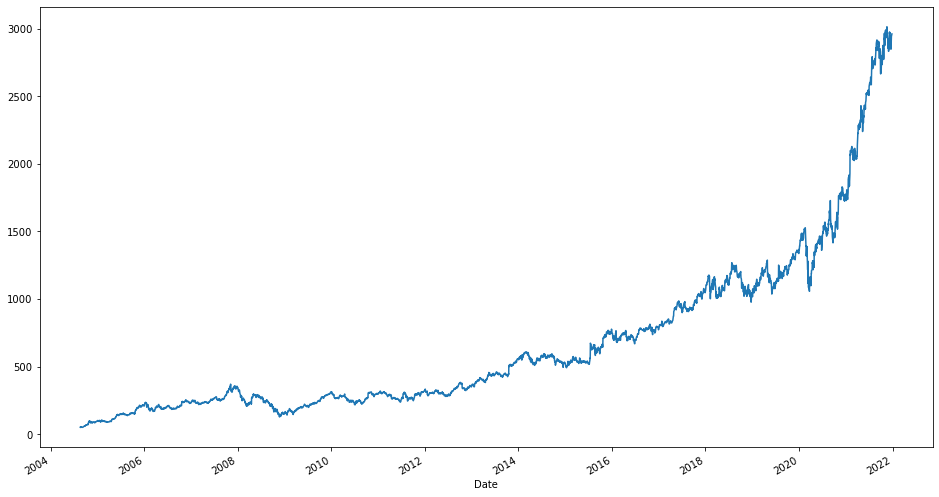

In [5]:
symbol_data['Adj Close'].plot(figsize=(16,9))

Plotting the autocorrelation matrix, suggests that only the Volume field may contain additional information. All other fields have a strong correlation with the Adjusted Close field and are likely to not improve a model that would include them as features.

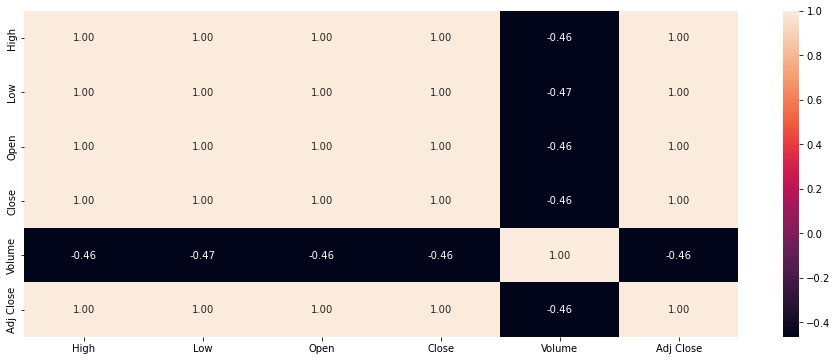

In [6]:
fig = plt.gcf()
fig.set_size_inches(16,6)
sns.heatmap(symbol_data.corr(), annot=True, fmt=".2f");

Let's rename columns for easier coding:

In [7]:
symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})

Next we define a function which takes a dataframe as an input and returns a dataframe with additional lagged columns backwards and forwards as specified by the n_in (backward values) and n_out (forward values) parameters. This function is build on a concept described in this [article](#ts_as_supervised_learning)

In [8]:
def df_to_lagged_features(df, n_in=1, n_out=0, dropnan=True):
    """
    Creates features for a data frame suitable for supervised learning.
    Arguments:
        df: Pandas dataframe.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series with lagged columns backwards and forwards suitable for supervised learning.
    """

    lagged_columns, lagged_column_names = list(), list()
    df_column_names = df.columns
	# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        lagged_columns.append(df.shift(i))
        lagged_column_names += [('%s(t-%d)' % (column_name, i)) for column_name in df_column_names]

    # add current value (moment t)
    lagged_column_names += [ '%s(t)' % (column_name) for column_name in df_column_names]
    lagged_columns.append(df)
    
    # future moments if any (t+1, ... t+n)
    if n_out >= 1:
        for i in range(1, n_out+1):
            lagged_columns.append(df.shift(-i))
            lagged_column_names += [('%s(t+%d)' % (column_name, i)) for column_name in df_column_names]
    
    # put it all together
    agg = concat(lagged_columns, axis=1)
    agg.columns = lagged_column_names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Let's create features as shifted 'ac' column. How many lagged values should we choose is not an exact science. We mainly look at 7 predicted values in the future, so we may want to choose a multiple of this number as the number of past values to learn from, in the hope that we will catch and short term trend. Thus, we'll choose n_in=30 and n_out=7 for the moment:

In [9]:
symbol_lag = df_to_lagged_features(symbol_data.loc[:, ['ac']], n_in=30, n_out=7)

In [10]:
symbol_lag

,ac(t-30),ac(t-29),ac(t-28),ac(t-27),ac(t-26),ac(t-25),ac(t-24),ac(t-23),ac(t-22),ac(t-21),...,ac(t-2),ac(t-1),ac(t),ac(t+1),ac(t+2),ac(t+3),ac(t+4),ac(t+5),ac(t+6),ac(t+7)
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-01,49.982655,53.952770,54.495735,52.239197,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,...,65.295258,64.558022,66.042458,67.277824,68.926643,68.284058,69.165749,68.607841,67.377457,68.443459
2004-10-04,53.952770,54.495735,52.239197,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,50.565468,...,64.558022,66.042458,67.277824,68.926643,68.284058,69.165749,68.607841,67.377457,68.443459,70.186920
2004-10-05,54.495735,52.239197,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,50.565468,49.818268,...,66.042458,67.277824,68.926643,68.284058,69.165749,68.607841,67.377457,68.443459,70.186920,70.734871
2004-10-06,52.239197,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,50.565468,49.818268,50.600338,...,67.277824,68.926643,68.284058,69.165749,68.607841,67.377457,68.443459,70.186920,70.734871,71.785927
2004-10-07,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,50.565468,49.818268,50.600338,50.958992,...,68.926643,68.284058,69.165749,68.607841,67.377457,68.443459,70.186920,70.734871,71.785927,74.301498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09,2928.550049,2922.580078,2965.409912,2875.479980,2917.260010,2935.800049,2973.659912,2984.820068,2987.030029,2984.969971,...,2960.729980,2974.409912,2962.120117,2973.500000,2934.090088,2899.409912,2947.370117,2896.770020,2856.060059,2848.030029
2021-12-10,2922.580078,2965.409912,2875.479980,2917.260010,2935.800049,2973.659912,2984.820068,2987.030029,2984.969971,2932.520020,...,2974.409912,2962.120117,2973.500000,2934.090088,2899.409912,2947.370117,2896.770020,2856.060059,2848.030029,2884.409912
2021-12-13,2965.409912,2875.479980,2917.260010,2935.800049,2973.659912,2984.820068,2987.030029,2984.969971,2932.520020,2934.959961,...,2962.120117,2973.500000,2934.090088,2899.409912,2947.370117,2896.770020,2856.060059,2848.030029,2884.409912,2938.979980


Let's now prepare y and X, the predicted values and the input for any model respectively.

y would be the 7 values of the 'ac' column ac(t+1)..ac(t+7)

X would be all other columns from ac(t-30) until ac(t)

In [11]:
n_out = 7
y_columns = [ 'ac(t+{0})'.format(i) for i in range(1, n_out+1) ]
X = symbol_lag.drop(y_columns, axis=1)
y = symbol_lag.drop(X.columns, 1)

In [12]:
y.head()

,ac(t+1),ac(t+2),ac(t+3),ac(t+4),ac(t+5),ac(t+6),ac(t+7)
Date,,,,,,,
2004-10-01,67.277824,68.926643,68.284058,69.165749,68.607841,67.377457,68.443459
2004-10-04,68.926643,68.284058,69.165749,68.607841,67.377457,68.443459,70.186920
2004-10-05,68.284058,69.165749,68.607841,67.377457,68.443459,70.186920,70.734871
2004-10-06,69.165749,68.607841,67.377457,68.443459,70.186920,70.734871,71.785927
2004-10-07,68.607841,67.377457,68.443459,70.186920,70.734871,71.785927,74.301498


In [13]:
X.head()

,ac(t-30),ac(t-29),ac(t-28),ac(t-27),ac(t-26),ac(t-25),ac(t-24),ac(t-23),ac(t-22),ac(t-21),...,ac(t-9),ac(t-8),ac(t-7),ac(t-6),ac(t-5),ac(t-4),ac(t-3),ac(t-2),ac(t-1),ac(t)
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-01,49.982655,53.952770,54.495735,52.239197,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,...,59.457142,58.699978,58.968971,60.184414,59.691261,58.909195,63.193138,65.295258,64.558022,66.042458
2004-10-04,53.952770,54.495735,52.239197,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,50.565468,...,58.699978,58.968971,60.184414,59.691261,58.909195,63.193138,65.295258,64.558022,66.042458,67.277824
2004-10-05,54.495735,52.239197,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,50.565468,49.818268,...,58.968971,60.184414,59.691261,58.909195,63.193138,65.295258,64.558022,66.042458,67.277824,68.926643
2004-10-06,52.239197,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,50.565468,49.818268,50.600338,...,60.184414,59.691261,58.909195,63.193138,65.295258,64.558022,66.042458,67.277824,68.926643,68.284058
2004-10-07,52.802086,53.753517,52.876804,50.814533,50.993862,49.937820,50.565468,49.818268,50.600338,50.958992,...,59.691261,58.909195,63.193138,65.295258,64.558022,66.042458,67.277824,68.926643,68.284058,69.165749


We are now ready to dive in and apply some tabular machine learning algorithms. So:

<a id='dive_in'></a>

## Dive in. Easy come easy go.

Lets create train and test data sets then apply some tabular algos using the MultiOutputRegressor to predict the multiple values of y at the same time.

The mean_absolute_percentage_error is the output metric we are interested in:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [15]:
%%time

model = LinearRegression(normalize=True)
model = MultiOutputRegressor(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.025737343475474312
CPU times: user 145 ms, sys: 9.82 ms, total: 155 ms
Wall time: 23.9 ms


Great! At 2.5% we are under the target value of 5%. Can Random Forest or XGBoost improve the outcome?

In [16]:
%%time

model = RandomForestRegressor(n_estimators=100, random_state=0)
model = MultiOutputRegressor(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.02075091074980246
CPU times: user 30.8 s, sys: 122 ms, total: 30.9 s
Wall time: 29.7 s


In [17]:
%%time

model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
model = MultiOutputRegressor(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.02160753428438072
CPU times: user 10min 2s, sys: 12.3 s, total: 10min 15s
Wall time: 45.4 s


Both Random Forest and XGB improve on the linear regressor result, so it seems we have a solution - an easy one!

Sadly, this is not the case. The reason for this is that beacause of the lagged features, data from the test set appears in the training set, so to some extent we use the same data for training and testing - a sure recipe for overfitting.

Let's try again, this time selecting the test set at the end of the time series, and ensuring there is no overlap between the training set and the testing set.

In [18]:
n_in = 30
n_out = 7
test_size = n_out

not_for_train_size = n_out + n_in + test_size

X_train = X.iloc[:len(X)-not_for_train_size]
X_test = X.iloc[-test_size:]

y_train = y.iloc[:len(y)-not_for_train_size]
y_test = y.iloc[-test_size:]

In [19]:
%%time

model = LinearRegression(normalize=True)
model = MultiOutputRegressor(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.020406005474708822
CPU times: user 579 ms, sys: 22.5 ms, total: 602 ms
Wall time: 46.9 ms


In [20]:
%%time
model = RandomForestRegressor(n_estimators=100, random_state=0)

model = MultiOutputRegressor(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.043738817321649304
CPU times: user 39.9 s, sys: 89.6 ms, total: 40 s
Wall time: 38.2 s


In [21]:
%%time

model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
model = MultiOutputRegressor(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

0.06929569000978325
CPU times: user 11min 41s, sys: 13.9 s, total: 11min 54s
Wall time: 52.9 s


Different story, right? The linear model still gives a good result with a 2% relative error, but both the Random Forest and XGB regressors have worse results. 

In addition, these algos seem to take orders of magnitudes more time to train than the linear model. We have run quite a number of time consuming experiments, which we are not going to present here. In all these experiments, the linear model produced better outcomes and usable runtimes.

The end result is that, from now onwards we will only use the linear regressor.

A small note to say, that, although not presented here, we also tested the RegressorChain of the sklearn.multioutput module. It consistently produces worse results than the MultiOutputRegressor, presumably because the errors produced in the first predicted values (say ac(t+1)), which are used to predict next values (ac(t+2) etc) in the chain, amplify the errors in the predicted values down the chain. So, we are only using the MultiOutputRegressor to predict multiple values in the future.

The following function will compute the mean percentage error for a linear model for a given data set and back and forth lagged values:

In [22]:
%%time

def make_mape(df, n_in, n_out, model='linear'):
    """
    Computes the mean absolute percentage error of a linear model fit over df['ac'] time series with n_in + 1 history values, and n_out predicted values
    Arguments:
        df: Pandas dataframe which should include the Adjuste Close 'ac' column
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Mean absolute percentage error of the linear model fit to the observations
    """
    
    # create lagged features
    dflag = df_to_lagged_features(df.loc[:, ['ac']], n_in=n_in, n_out=n_out)

    # drop columns ac(t+1)..ac(t+2) from dflag to create X features
    columns_to_drop = [ 'ac(t+{0})'.format(i) for i in range(1, n_out+1) ]
    X = dflag.drop(columns_to_drop, 1)

    # predicted values are all non X columns
    y = dflag.drop(X.columns, 1)

    # create test/train datasets
    test_size = n_out

    not_for_train_size = n_out + n_in + test_size

    X_train = X.iloc[:len(X)-not_for_train_size]
    X_test = X.iloc[-test_size:]

    y_train = y.iloc[:len(y)-not_for_train_size]
    y_test = y.iloc[-test_size:]

    # fit and predict a multiclass linear model
    model = LinearRegression(normalize=True)
    model = MultiOutputRegressor(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return mape

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 4.53 µs


<a id='one_model'></a>

## One model or many models?

Intuitively, this is easy to answer: one model for all market symbols will likely average among all stocks. It might be a good model for the average market and a few stocks that really move the market, but otherwise it would probably fair poorly on most of the stocks.

Let's further enforce this (weak) justification by looking at the data of a few stocks.

We'll use a list of stock symbols from the [Nasdaq website.](#nasdaq_stock_symbols) downloaded into a file called symbols.csv.

Let's load the data and plot the Adjusted Close value for the last 6 years for a few stocks:

In [23]:
symbols_data = pd.read_csv('symbols.csv')
symbols_data = symbols_data.sort_values(['Market Cap'], ascending=[False])
symbols_data

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
18,AAPL,Apple Inc. Common Stock,$172.26,-7.04,-3.926%,2.986530e+12,United States,1980.0,149956379,Technology,Computer Manufacturing
5006,MSFT,Microsoft Corporation Common Stock,$324.90,-9.75,-2.913%,2.439343e+12,United States,1986.0,34986695,Technology,Computer Software: Prepackaged Software
3354,GOOG,Alphabet Inc. Class C Capital Stock,$2896.77,-50.60,-1.717%,1.922772e+12,United States,2004.0,1368942,Technology,Internet and Information Services
3355,GOOGL,Alphabet Inc. Class A Common Stock,$2888.90,-39.92,-1.363%,1.917548e+12,United States,NaN,1681623,Technology,Internet and Information Services
452,AMZN,Amazon.com Inc. Common Stock,$3377.42,-88.88,-2.564%,1.712851e+12,United States,1997.0,3038172,Consumer Services,Catalog/Specialty Distribution
...,...,...,...,...,...,...,...,...,...,...,...
8073,WRB^G,W.R. Berkley Corporation 4.25% Subordinated De...,$26.03,0.21,0.813%,NaN,United States,NaN,4904,NaN,NaN
8074,WRB^H,W.R. Berkley Corporation 4.125% Subordinated D...,$25.53,0.05,0.196%,NaN,United States,NaN,5614,NaN,NaN
8087,WSO/B,Watsco Inc.,$307.19,0.00,0.00%,NaN,United States,NaN,66,NaN,NaN
8135,XFLT^A,XAI Octagon Floating Rate & Alternative Income...,$25.98,0.00,0.00%,NaN,United States,NaN,34,NaN,NaN


We have a few null values on the Market Cap column, so let's drop them.

In [24]:
symbols_data = symbols_data[symbols_data['Market Cap'].notna()].sort_values(['Market Cap'], ascending=[False])
len(symbols_data)

7795

Lets select the first, the 10th, the 100th and 1000th stock symbols by market capitalisation:

In [25]:
ranks = [0, 9, 99, 999]
symbols = [ symbols_data.iloc[r]['Symbol'] for r in ranks ]
symbols

['AAPL', 'JPM', 'MRNA', 'DAVA']

In [26]:
dframes = []
for s in symbols:
    s_data = get_symbol_data(s, start_date='2016-01-01')
    s_data = s_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':s})
    dframes.append(s_data[s])

ticks = pd.concat(dframes, axis=1)
ticks

,AAPL,JPM,MRNA,DAVA
Date,,,,
2016-01-04,24.251434,54.278229,NaN,NaN
2016-01-05,23.643715,54.372074,NaN,NaN
2016-01-06,23.181013,53.587173,NaN,NaN
2016-01-07,22.202667,51.420128,NaN,NaN
2016-01-08,22.320068,50.268372,NaN,NaN
...,...,...,...,...
2021-12-21,172.990005,156.089996,268.140015,154.100006
2021-12-22,175.639999,156.699997,251.360001,159.740005
2021-12-23,176.279999,157.259995,249.990005,163.119995


<AxesSubplot:xlabel='Date'>

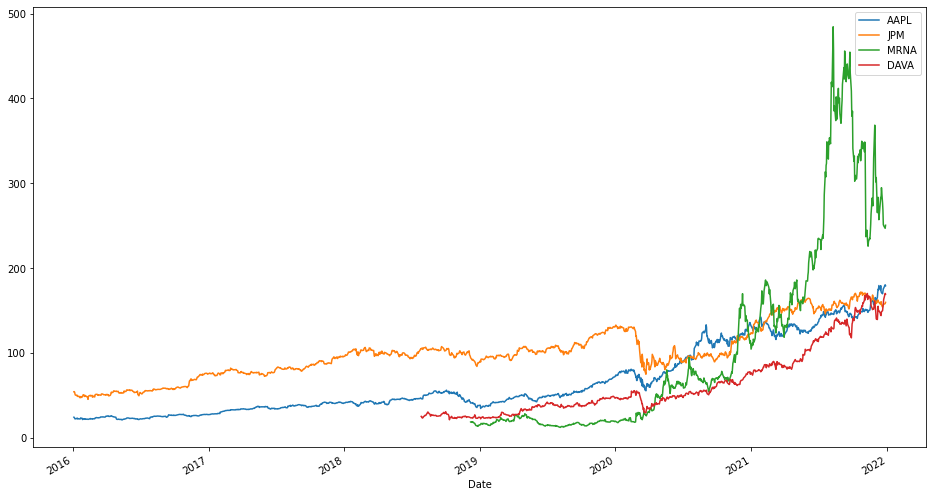

In [27]:
ticks.plot(figsize=(16,9))

Looking at the above plot, it is reasonable to suspect a linear model will perform poorly on the MRNA stock, let alone a combination of the four.

This is a weak, informal justification for this decision, but we'll generate one model per stock. The training time is well under a second per stock so, we'll be able to generate the respective model(s) in a reasonable time.

Let's also observe that the subset of companies with a market valuation of at least $1bn make more than 98% of the total market. We'll restrict our analysis to this subset which is a list of 2844 companies:

In [28]:
len(symbols_data[symbols_data['Market Cap'] >= 1000000000])

2844

<AxesSubplot:xlabel='Rank of companies ordered descending by Market Cap', ylabel='Cumulative Market Cap tens of $tn'>

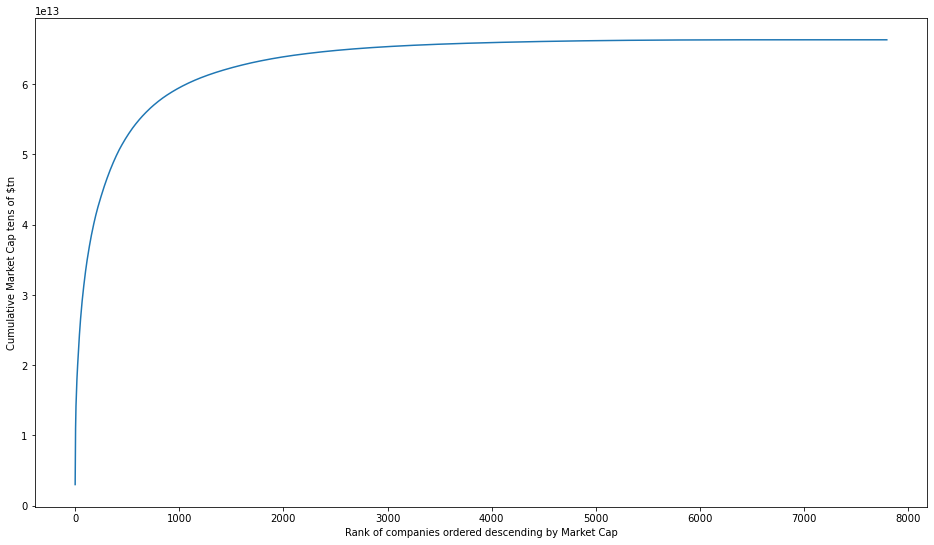

In [29]:
symbols_data.reset_index()['Market Cap'].cumsum().plot(figsize=(16,9), ylabel='Cumulative Market Cap tens of $tn', xlabel='Rank of companies ordered descending by Market Cap')

In [30]:
symbols_data[symbols_data['Market Cap'] >= 1000000000]['Market Cap'].sum() / symbols_data['Market Cap'].sum() 

0.9831569804808304

In [31]:
symbols_data = symbols_data[symbols_data['Market Cap'] >= 1000000000]
len(symbols_data)

2844

<a id='how_much_lagged'></a>

## How much lagged data do we need?

Let's look at a couple of companies, GOOG, TSLA and see if we can generalise what we'll learn. At a glance it is hard to say whether one stock or the other will fare better with our linear regressor:

<AxesSubplot:xlabel='Date'>

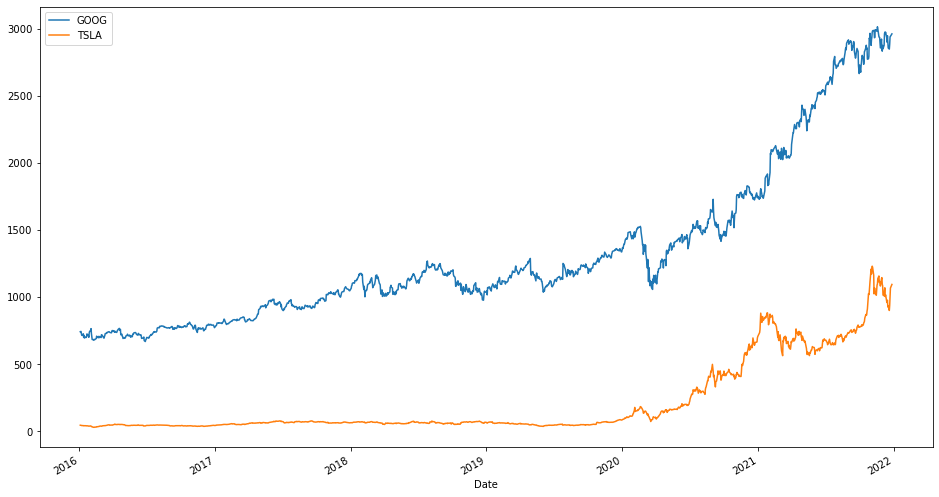

In [32]:
symbols = ['GOOG', 'TSLA']
dframes = []
for s in symbols:
    s_data = get_symbol_data(s, '2016-01-01')
    s_data = s_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':s})
    dframes.append(s_data[s])

ticks = pd.concat(dframes, axis=1)

ticks.plot(figsize=(16,9))

Next, we set the predicted values n_out to 7, while we fit linear regressors for different training values where the training sets have back values as features ranging from 1 to 60. We then plot the mean percentage errors (y axis) versus the number of lagged features in the model (X axis) for both TSLA and GOOG:

CPU times: user 25.2 s, sys: 516 ms, total: 25.7 s
Wall time: 3.23 s


<AxesSubplot:xlabel='Number of lagged features', ylabel='MAPE for a multioutput linear model predicting 7 values ahead'>

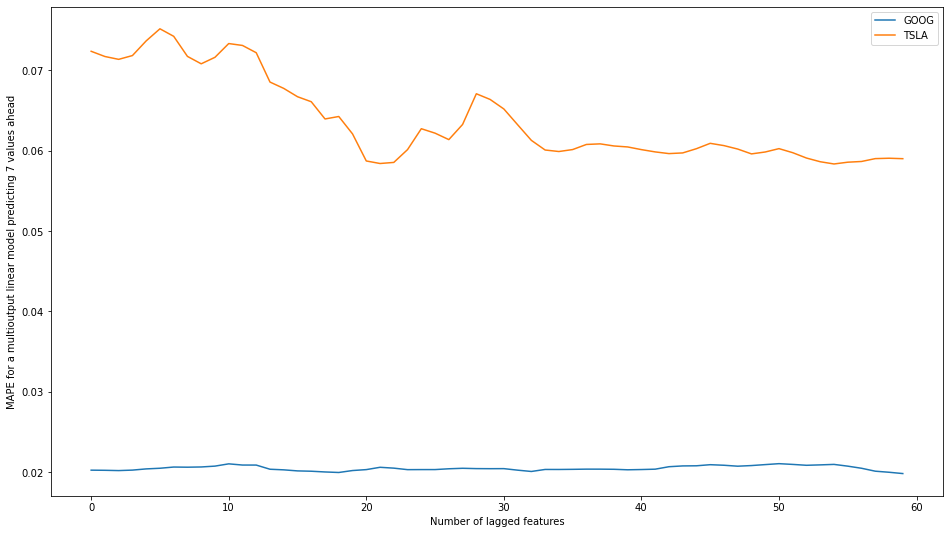

In [33]:
%%time
symbols = ['GOOG', 'TSLA']
mape_records = list()

for s in symbols:
    symbol_data = get_symbol_data(s)
    symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})
    mape_list = []
    for n_in in range(1, 61):
        mape_list.append(make_mape(symbol_data, n_in, n_out=7))
    mape_records.append(mape_list)

df1 = pd.DataFrame.from_records(mape_records).transpose()
df1.columns = symbols
df1.plot(figsize=(16,9), xlabel='Number of lagged features', ylabel='MAPE for a multioutput linear model predicting 7 values ahead')

Looking at the graph above there seems to be no benefit of retaining more than 20 lagged values for our linear regressor. Plotting GOOG and TSLA separately make it more clear.

CPU times: user 13.1 s, sys: 240 ms, total: 13.3 s
Wall time: 1.67 s


<AxesSubplot:xlabel='Number of lagged features', ylabel='MAPE for a multioutput linear model predicting 7 values ahead'>

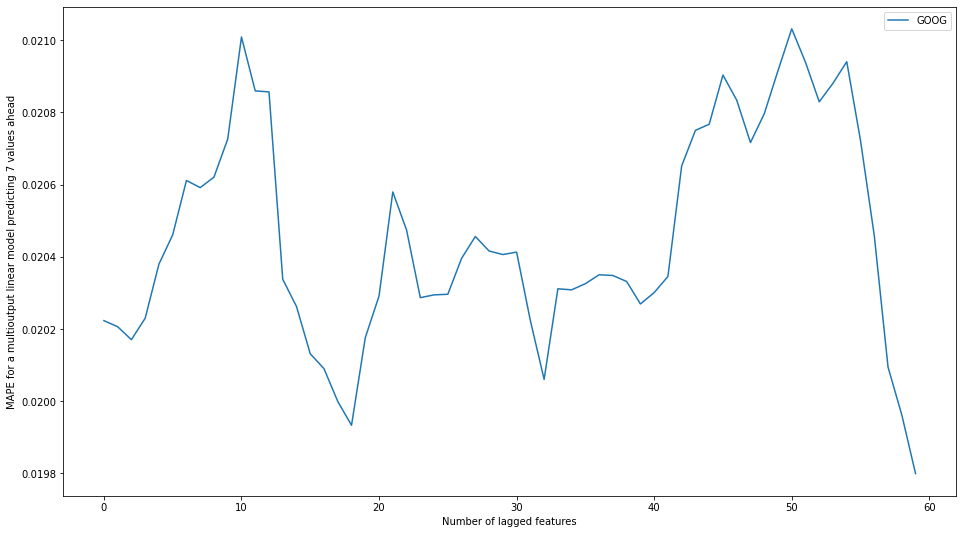

In [34]:
%%time
symbol_data = get_symbol_data('GOOG')
symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})

mape_list = []

for n_in in range(1, 61):
    mape_list.append(make_mape(symbol_data, n_in, n_out=7))

pd.DataFrame(mape_list).rename(columns={0:'GOOG'}).plot(figsize=(16,9), xlabel='Number of lagged features', ylabel='MAPE for a multioutput linear model predicting 7 values ahead')

CPU times: user 12.3 s, sys: 232 ms, total: 12.6 s
Wall time: 1.57 s


<AxesSubplot:xlabel='Number of lagged features', ylabel='MAPE for a multioutput linear model predicting 7 values ahead'>

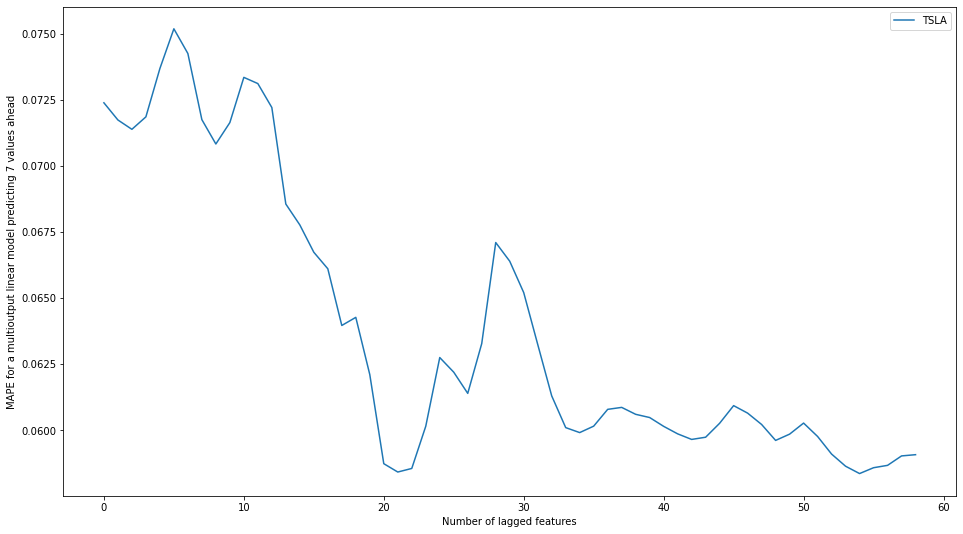

In [35]:
%%time
symbol_data = get_symbol_data('TSLA')
symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})

mape_list = []

for n_in in range(1, 60):
    mape_list.append(make_mape(symbol_data, n_in, n_out=7))

pd.DataFrame(mape_list).rename(columns={0:'TSLA'}).plot(figsize=(16,9), xlabel='Number of lagged features', ylabel='MAPE for a multioutput linear model predicting 7 values ahead')

So we think of retaining no more than 20 lagged features for our linear regressor. Let's see if this assuption holds for 10 random stocks from our symbols_data.

For replicability of this notebook, we use "random.seed(313)" in all code below where a random process is used.

In [36]:
random.seed(313)
symbols = random.sample(symbols_data['Symbol'].to_list(), 10)
symbols

['RDWR', 'ARGX', 'FLNG', 'VALN', 'ALHC', 'BBL', 'LII', 'FANG', 'INFO', 'FOCS']

In [37]:
%%time
mape_records = []
for symbol in symbols:
    symbol_data = get_symbol_data(symbol)
    symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})
    mape_list = []
    for n_in in range(1, 60):
        try:
            mape_list.append(make_mape(symbol_data, n_in, n_out=7))
        except:
            # we don't catch this exception as it is generated when there is not enough data to derive the lagged history features
            continue
    mape_records.append(mape_list)

CPU times: user 1min 50s, sys: 2.33 s, total: 1min 52s
Wall time: 14.1 s


<AxesSubplot:xlabel='Number of lagged features', ylabel='MAPE for a multioutput linear model predicting 7 values ahead'>

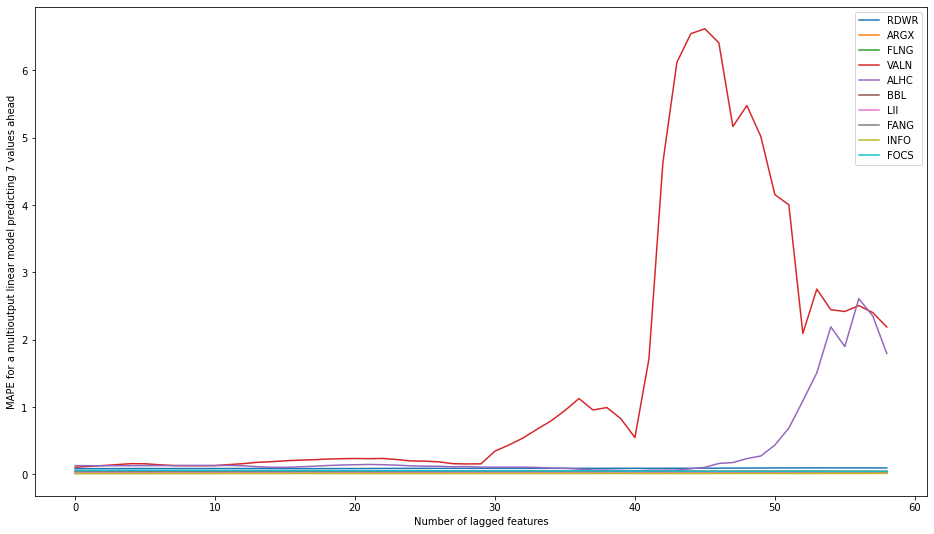

In [38]:
df1 = pd.DataFrame.from_records(mape_records).transpose()
df1.columns = symbols
df1.plot(figsize=(16,9), xlabel='Number of lagged features', ylabel='MAPE for a multioutput linear model predicting 7 values ahead')

The above plot still sustains our 20 lagged features approach. But, let's do further tests in support for this decision:

<a id='how_much_data'></a>

## How much train data do we need?

Here, again, we try to compromise between two facts of intuition:

On one hand, on stocks having a clear trand we would likely want a long time series to capture the long trend.

On the other hand, irregular noisy time series will extract little information from a long time series.

So far we used all the data history from yahoo which of course has different lenghts for different stocks.

Let's see how the mean absolute percentage error (mape) changes when picking random periods of 1 to 10 years in length respectively from the history of a stock. We repeat this random selection 30 times.

We'll repeat the above process 10 times for GOOG which looks to be a more stable stock, and compare it with TSLA which appears to have more variability.

In [39]:
%%time
random.seed(313)

symbol = 'GOOG'
symbol_data = get_symbol_data(symbol, start_date='2000-01-01')
symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})

mape_values = {k:list() for k in range(1,11)}
for i in range(30):
    for period in range(1, 11):
        # choose a random start; reserve at least 252*period at the end of the time series
        # 252 is roughly the length of a trading year in days
        start = random.choice(range(len(symbol_data.iloc[:-252*period])))
        mape_values[period].append(make_mape(symbol_data.iloc[start:start+252*period], n_in=19, n_out=7))

for year in range(1,11):
    print('{:2} {:.3f}'.format(year, mean(mape_values[year])))

 1 0.030
 2 0.027
 3 0.024
 4 0.024
 5 0.021
 6 0.020
 7 0.022
 8 0.019
 9 0.016
10 0.019
CPU times: user 42.4 s, sys: 828 ms, total: 43.2 s
Wall time: 5.42 s


For GOOG, the longer the better it seems. A 9 year period produces the best outcome, but of course this is a random simulation so with a different random seed, the outcome will likely be different. Let's look at another symbol, TSLA:

In [40]:
%%time
random.seed(313)

symbol = 'TSLA'
symbol_data = get_symbol_data(symbol, start_date='2000-01-01')
symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})

mape_values = {k:list() for k in range(1,11)}
for i in range(30):
    for period in range(1, 11):
        # choose a random start; reserve at least 252*period at the end of the time series
        start = random.choice(range(len(symbol_data.iloc[:-252*period])))
        mape_values[period].append(make_mape(symbol_data.iloc[start:start+252*period], n_in=19, n_out=7))

for year in range(1,11):
    print('{:2} {:.3f}'.format(year, mean(mape_values[year])))

 1 0.043
 2 0.050
 3 0.046
 4 0.036
 5 0.051
 6 0.061
 7 0.052
 8 0.060
 9 0.064
10 0.060
CPU times: user 43.4 s, sys: 732 ms, total: 44.2 s
Wall time: 5.53 s


For TSLA more history data tends to amplify the prediction error, sustaining the idea of TSLA containing more randomness than GOOG, thus being harder to predict.

Let's see if we look at a sample of 10 arbitrary stocks:

In [41]:
random.seed(313)
symbols = random.sample(symbols_data['Symbol'].to_list(), 10)
print(symbols)

['RDWR', 'ARGX', 'FLNG', 'VALN', 'ALHC', 'BBL', 'LII', 'FANG', 'INFO', 'FOCS']


In [42]:
%%time

symbols_mape_values = {}
for symbol in symbols:
    symbol_data = get_symbol_data(symbol, start_date='2000-01-01')
    symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})

    mape_values = {k:list() for k in range(1,11)}
    for i in range(30):
        for period in range(1, 11):
            try:
                # choose a random start; reserve at least 252*period at the end of the time series
                start = random.choice(range(len(symbol_data.iloc[:-252*period])))
                mape_values[period].append(make_mape(symbol_data.iloc[start:start+252*period], n_in=20, n_out=7))
            except:
                continue
    symbols_mape_values[symbol] = mape_values

yearly_error_means = { k:list() for k in range(1,11) }
for symbol in symbols:
    print('{:6}'.format(symbol), end='')
    for k in mape_values:
        try:
            print('{:.3f}  '.format(mean(symbols_mape_values[symbol][k])), end='')
            yearly_error_means[k].append(mean(symbols_mape_values[symbol][k]))
        except:
            continue
    print()

RDWR  0.039  0.038  0.035  0.028  0.035  0.030  0.034  0.033  0.023  0.025  
ARGX  0.054  0.041  0.040  0.034  
FLNG  0.054  0.035  
VALN  
ALHC  
BBL   0.036  0.036  0.040  0.039  0.038  0.032  0.035  0.037  0.027  0.029  
LII   0.036  0.027  0.025  0.028  0.023  0.023  0.031  0.024  0.023  0.024  
FANG  0.055  0.051  0.029  0.038  0.047  0.074  0.052  0.051  0.034  
INFO  0.024  0.018  0.021  0.018  0.028  0.016  0.017  
FOCS  0.048  0.039  0.031  
CPU times: user 3min 50s, sys: 4.31 s, total: 3min 54s
Wall time: 29.4 s


And the average error per year for the combine 10 stocks above:

In [43]:
print('{:6}'.format('ymean'), end='')
for y in range(1, 11):
    print('{:.3f}  '.format(mean(yearly_error_means[y])), end='')

ymean 0.043  0.035  0.032  0.031  0.034  0.035  0.034  0.036  0.027  0.026  

The data above provides anecdotic evidence that a group of stocks may start capturing market trend data. In this context, more data tend to fair better. In our sample above, using data from the last 10 years produced the lowest absolute percentage error at 2.6%.

<a id='test_all'></a>

## Test (almost) all the data

For this section we downloaded all available data from Yahoo Finance for all the stocks having a market valuation of $1bn or more. This takes a considerable amont of time, close to 3 hours, so it is difficult to replicate, but we feel it is worth presenting the results nevertheless.

The code to download the respective data is (uncomment and run it replicate the results below):

In [44]:
# %%time
# for symbol in symbols_data['Symbol']:
#     get_symbol_data(symbol, start_date='1900-01-01')

Next, for each stock symbol we pick an arbitrary start training period of 1 to 10 years (if it exists), fit a linear model and calculate the mean absolute percentage error for predicting 7 days in advance the stock's adjusted close value. We repeat this random proces 10 times for each stock. Then, we average the errors for each period of 1 to 10 years and present the results.

In [45]:
%%time

random.seed(313)

all_symbols_mape_values = {}
for symbol in symbols_data['Symbol'].to_list():
    try:
        symbol_filename = 'data/{0}.pickle'.format(symbol)
        symbol_data = pickle.load(open(symbol_filename, 'rb'))
    except:
        continue
        
    symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})

    mape_values = { k:list() for k in range(1,11) }
    for period in range(1, 11):
        try:
            # choose a random start; reserve at least 252*period at the end of the time series
            start = random.choice(range(len(symbol_data.iloc[:-252*period])))
            mape_values[period].append(make_mape(symbol_data.iloc[start:start+252*period], n_in=20, n_out=7))
        except:
            continue
    all_symbols_mape_values[symbol] = mape_values

CPU times: user 48min 27s, sys: 55.7 s, total: 49min 23s
Wall time: 6min 11s


In [46]:
# calculate the average error per year
yearly_error_means = { k:list() for k in range(1,11) }
for symbol in symbols_data['Symbol'].to_list():
    # print('{:6}'.format(symbol), end='')
    for k in range(1, 11):
        try:
            # print('{:.3f}  '.format(mean(all_symbols_mape_values[symbol][k])), end='')
            yearly_error_means[k].append(mean(all_symbols_mape_values[symbol][k]))
        except:
            continue

print('{:6}'.format('ymean'), end='')
for y in range(1, 11):
    print('{:.3f}  '.format(mean(yearly_error_means[y])), end='')

ymean 0.048  0.044  0.038  0.037  0.037  0.035  0.035  0.034  0.034  0.033  

Working with the whole market data shows a clear trend: the longer the better. This observation is in accordance with the fact that the market has a long trend of increasing its value by about 10% per year.

There is a significant error decrease jumping from 1 to 2 years worth of data. After that there is progressive improvement but smaller and smaller as the history increases.

One last test is presented below: for each stock and using the most recent data, we train and predict 7 values in "future" using 1, 2, and up to 10 years of historic data. We than average the results per year and display the results.

In [47]:
%%time

all_symbols_mape_values = {}
for symbol in symbols_data['Symbol'].to_list():
    try:
        symbol_filename = 'data/{0}.pickle'.format(symbol)
        symbol_data = pickle.load(open(symbol_filename, 'rb'))
    except:
        continue
        
    symbol_data = symbol_data.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 'Volume':'v', 'Adj Close':'ac'})

    mape_values = { k:list() for k in range(1,11) }
    for period in range(1, 11):
        try:
            # choose a start moment 1, 2, ... 10 years back from the current moment
            start = -252*period
            mape_values[period].append(make_mape(symbol_data.iloc[start:], n_in=20, n_out=7))
        except:
            continue
    all_symbols_mape_values[symbol] = mape_values

CPU times: user 1h 4min 12s, sys: 1min 13s, total: 1h 5min 25s
Wall time: 8min 11s


In [48]:
yearly_error_means = { k:list() for k in range(1,11) }
for symbol in symbols_data['Symbol'].to_list():
    # print('{:6}'.format(symbol), end='')
    for k in range(1, 11):
        try:
            # print('{:.3f}  '.format(mean(all_symbols_mape_values[symbol][k])), end='')
            yearly_error_means[k].append(mean(all_symbols_mape_values[symbol][k]))
        except:
            continue

print('{:6}'.format('ymean'), end='')
for y in range(1, 11):
    print('{:.3f}  '.format(mean(yearly_error_means[y])), end='')

ymean 0.054  0.049  0.049  0.048  0.048  0.048  0.048  0.048  0.048  0.048  

Again, working with most of the market data shows a good improvement after the first year, and practically reaching a flat plateau immediately after, but still showing a trend of improvement with more history used for training. 

Arguably, it is not worth training on a data set longer than a year and maybe no longer than 3 or 4 years. This is consistent with our previous randomised test above. 

What is really surprising is that the long term average 7 days prediction absolute percentage error is exactly just under 5% - coinciding with the objective of this homework. Is this maybe a systemic property of the stock market when aproached with simple analisys tools?

<a id='conclusion'></a>

## Conclusion

We have shown that on average, the Nasdaq stock market can be predicted with a simple linear model which learns from the past 20 values of the Adjusted Close metric.

An average of under 5% absolute percentage error can be expected by predicting the next 7 days Adjusted Close values using at leat one year of history data.

This work also hints that significantly improving the 5% error margin, to say, below 3% is out of reach using the method above.

Where's money there is skewness and we saw this as well here, by noticing that about a third of the listed Nasdaq stocks make practically the whole marked with over 98% of the total Nasdaq market value.

<a id='external_links'></a>

## External links

<a id='itcp'></a>

Udacity MLND Capstone Project Description - Investment and Trading https://docs.google.com/document/d/1ycGeb1QYKATG6jvz74SAMqxrlek9Ed4RYrzWNhWS-0Q/pub

<a id='random_walks'></a>

Wikipedia Random Walks for stock prices https://en.wikipedia.org/wiki/Random_walk_hypothesishttps://en.wikipedia.org/wiki/Random_walk_hypothesis

<a id='brownian_motion'></a>

Wikipedia Geometric Brownian motion https://en.wikipedia.org/wiki/Geometric_Brownian_motion

<a id='asr_1'></a>

What Is the Average Stock Market Return? https://www.nerdwallet.com/article/investing/average-stock-market-return

<a id='asr_2'></a>

Average Stock Market Return https://www.fool.com/investing/how-to-invest/stocks/average-stock-market-return/

<a id='yfinance'></a>

Download historical data in Yahoo Finance https://help.yahoo.com/kb/SLN2311.htmlAverage 

<a id='ts_as_supervised_learning'></a>

How to Convert a Time Series to a Supervised Learning Problem in Python https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

<a id='nasdaq_stock_symbols'></a>

Nasdaq stock symbols https://www.nasdaq.com/market-activity/stocks/screener